# **프로젝트 : 네이버 영화리뷰 감성분석 도전하기**

In [1]:
# !wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
# !wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
# !mv ratings_*.txt ~/work/sentiment_classification/data

In [2]:
# !pip install konlpy
# !git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
# %cd Mecab-ko-for-Google-Colab/
# !bash install_mecab-ko_on_colab_light_220429.sh

In [3]:
# !python --version

In [4]:
# !pip install gensim==4.3.2
# !pip install scipy==1.12.0 numpy==1.26.3

In [5]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

3.0.0
0.6.0
4.3.2


## **1) 데이터 준비와 확인**

In [6]:
import pandas as pd
import os

# 데이터를 읽어봅시다.
train_data = pd.read_table(os.getenv("HOME") + '/work/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table(os.getenv("HOME") + '/work/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [7]:
train_data['document'][0]

'아 더빙.. 진짜 짜증나네요 목소리'

- 몇줄 봐보니 리뷰와 라벨이 다를 수도 있는듯?

## **2) 데이터로더 구성**

In [8]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    # vocab = ['', '', '', ''] + [key for key, _ in counter]
    vocab = ['<PAD>', '<BOS>', '<UNK>', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        # return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

In [9]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [10]:
print(index_to_word)

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: '', 4: '.', 5: '영화', 6: '다', 7: '고', 8: '하', 9: '을', 10: '보', 11: '..', 12: '게', 13: ',', 14: '!', 15: '지', 16: '있', 17: '없', 18: '?', 19: '좋', 20: '나', 21: '었', 22: '만', 23: '는데', 24: '너무', 25: '봤', 26: '적', 27: '안', 28: '로', 29: '정말', 30: '음', 31: '것', 32: '아', 33: '네요', 34: '어', 35: '재밌', 36: '같', 37: '점', 38: '지만', 39: '진짜', 40: '했', 41: '기', 42: '에서', 43: '네', 44: '않', 45: '거', 46: '았', 47: '수', 48: '되', 49: '면', 50: 'ㅋㅋ', 51: '말', 52: '인', 53: '연기', 54: '주', 55: '내', 56: '최고', 57: '~', 58: '평점', 59: '이런', 60: '던', 61: '어요', 62: '할', 63: '왜', 64: '겠', 65: '해', 66: '1', 67: '스토리', 68: '습니다', 69: 'ㅋㅋㅋ', 70: '...', 71: '드라마', 72: '아니', 73: '생각', 74: '더', 75: '그', 76: '싶', 77: '사람', 78: '듯', 79: '때', 80: '감동', 81: '함', 82: '배우', 83: '본', 84: '까지', 85: '뭐', 86: '보다', 87: '알', 88: '만들', 89: '내용', 90: '볼', 91: '감독', 92: '라', 93: '그냥', 94: '재미', 95: '시간', 96: '지루', 97: '중', 98: '재미있', 99: '년', 100: '10', 101: '였', 102: '잼', 103: '사랑', 104: '못', 105:

In [11]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [12]:
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])

아 더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


## **3) 모델 구성을 위한 데이터 분석 및 가공**

In [13]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  16.971024731364448
문장길이 최대 :  117
문장길이 표준편차 :  12.844098490466033
pad_sequences maxlen :  42
전체 문장의 0.9342629991962691%가 maxlen 설정값 이내에 포함됩니다. 


In [14]:
import torch

def pad_sequences(data, maxlen):
    padded_data = []
    for sentence in data:
        if len(sentence) < maxlen:
            sentence = sentence + [0] * (maxlen - len(sentence))
        else:
            sentence = sentence[:maxlen]
        padded_data.append(sentence)
    return np.array(padded_data)

x_train_padded = pad_sequences(x_train, maxlen)
x_test_padded = pad_sequences(x_test, maxlen)

x_train_tensor = torch.tensor(x_train_padded, dtype=torch.long)
x_test_tensor = torch.tensor(x_test_padded, dtype=torch.long)

print(x_train_tensor.shape)
print(x_test_tensor.shape)

torch.Size([146182, 42])
torch.Size([49157, 42])


#### 패딩을 최대길이로 맞추지 않는 이유는?
- 계산량 폭증
- 메모리 낭비
- 학습 효율 저하
- 실질적 정보는 거의 안 늘어남

## **4) 모델 구성 및 validation set 구성**

#### **모델 구성** 

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
# word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)
# # → 하나의 단어가 16차원짜리 벡터 하나로 표현되는 것!!

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.lstm = nn.LSTM(word_vector_dim, 8, batch_first=True)
        self.fc1 = nn.Linear(8, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.embedding(x)
        x, (hn, cn) = self.lstm(x)
        x = x[:, -1, :]
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [16]:
class TextCNNModel(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(TextCNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.conv1 = nn.Conv1d(word_vector_dim, 16, kernel_size=7)
        self.conv2 = nn.Conv1d(16, 16, kernel_size=7)
        self.pool = nn.MaxPool1d(5)
        self.global_max_pooling = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(16, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.global_max_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [17]:
class BoEModel(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(BoEModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.global_max_pooling = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(word_vector_dim, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.global_max_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [18]:
model_A = SentimentModel(10000, 16)
model_B = TextCNNModel(10000, 16)
model_C = BoEModel(10000, 16)

print(model_A)
print(model_B)
print(model_C)

SentimentModel(
  (embedding): Embedding(10000, 16)
  (lstm): LSTM(16, 8, batch_first=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
TextCNNModel(
  (embedding): Embedding(10000, 16)
  (conv1): Conv1d(16, 16, kernel_size=(7,), stride=(1,))
  (conv2): Conv1d(16, 16, kernel_size=(7,), stride=(1,))
  (pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (global_max_pooling): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=16, out_features=8, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
BoEModel(
  (embedding): Embedding(10000, 16)
  (global_max_pooling): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=16, out_features=8, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


#### **validation set 구성**

In [19]:
# validation set 10000건 분리
x_val = x_train_tensor[:10000]
y_val = y_train[:10000]

# validation set을 제외한 나머지
partial_x_train = x_train_tensor[10000:]
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

torch.Size([136182, 42])
(136182,)


## **5) 모델 훈련 개시**

In [20]:
# GPU 환경 및 상태 확

import torch

# GPU 사용 가능 여부
print(torch.cuda.is_available())

# 어떤 GPU가 잡혔는지
if torch.cuda.is_available():
    print("GPU 이름:", torch.cuda.get_device_name(0))
    print("GPU 개수:", torch.cuda.device_count())
else:
    print("GPU를 사용할 수 없습니다.")

True
GPU 이름: NVIDIA GeForce RTX 4080 SUPER
GPU 개수: 1


In [21]:
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


def train_one_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=20):
    # 4. 학습 기록용 변수 정의
    
    history = {
        "train_losses": [],
        "val_losses": [],
        "train_accs": [],
        "val_accs": [],
    }
    
    # 5. Epoch 루프
    for epoch in range(epochs):
    
        # 6. 학습 단계 (Training)
        model.train()
        # “학습 모드(training mode)”로 전환 : Dropout, batchnorm
        # 그런데 기존 코드에서는 Dropout, batchnorm이 정의가 안 돼 있는듯?
        running_loss = 0.0
        correct = 0
        total = 0
    
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # 이전 배치의 gradient 초기화
    
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)  # 예측값과 정답으로 손실 계산
            loss.backward()  # 역전파 → gradient 계산
            optimizer.step()  # gradient를 이용해 가중치 업데이트
    
            running_loss += loss.item()
    
            # 7. 학습 정확도 계산
            predicted = (outputs.squeeze() > 0.5).float()  # sigmoid 출력이 0.5 이상이면 1(긍정), 아니면 0(부정)
            correct += (predicted == labels).sum().item()  # 맞은 개수와 전체 개수 누적
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        history["train_losses"].append(train_loss)
        history["train_accs"].append(train_acc)
    
        # 8. 검증 단계 (Validation)
        model.eval()  # 검증 단계 (Validation)
        val_loss = 0.0
        val_correct = 0
        val_total = 0
    
        with torch.no_grad():  # gradient 계산 비활성화 (메모리 절약, 속도 증가)
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs.squeeze(), labels)
    
                val_loss += loss.item()
                predicted = (outputs.squeeze() > 0.5).float()
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
    
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        history["val_losses"].append(val_loss)
        history["val_accs"].append(val_acc)
    
        # 9. Epoch 결과 출력
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {history["train_losses"][-1]:.4f}, Train Accuracy: {history["train_accs"][-1]:.4f} - "
              f"Validation Loss: {history["val_losses"][-1]:.4f}, Validation Accuracy: {history["val_accs"][-1]:.4f}")

    return history

In [22]:
# 1. NumPy → Torch Tensor 변환
partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)

x_val_tensor = torch.tensor(x_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float)

# 2. Dataset, Dataloader 생성
train_dataset = TensorDataset(partial_x_train_tensor, partial_y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

/tmp/ipykernel_17910/3851606449.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
/tmp/ipykernel_17910/3851606449.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_tensor = torch.tensor(x_val, dtype=torch.long)


In [23]:
# 3. 옵티마이저와 손실함수 정의
optimizer_A = optim.Adam(model_A.parameters(), lr=1e-3)  # model_A 옵티마이저 설정
optimizer_B = optim.Adam(model_B.parameters(), lr=1e-3)  # model_B 옵티마이저 설정
optimizer_C = optim.Adam(model_C.parameters(), lr=1e-3)  # model_C 옵티마이저 설정


loss_fn = torch.nn.BCELoss()
# BCELoss : Binary Cross Entropy Loss, sigmoid 출력(0~1)과 정답(0/1)을 비교하는 이진 분류용 손실함수



In [24]:
history_model_A = train_one_model(
    model=model_A,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_A,
    loss_fn=loss_fn,
    epochs=30
)

Epoch 1/30 - Train Loss: 0.6932, Train Accuracy: 0.5025 - Validation Loss: 0.6927, Validation Accuracy: 0.5081
Epoch 2/30 - Train Loss: 0.6927, Train Accuracy: 0.5057 - Validation Loss: 0.6921, Validation Accuracy: 0.5033
Epoch 3/30 - Train Loss: 0.6835, Train Accuracy: 0.5427 - Validation Loss: 0.6778, Validation Accuracy: 0.5736
Epoch 4/30 - Train Loss: 0.6511, Train Accuracy: 0.6372 - Validation Loss: 0.6600, Validation Accuracy: 0.6034
Epoch 5/30 - Train Loss: 0.6375, Train Accuracy: 0.6552 - Validation Loss: 0.6387, Validation Accuracy: 0.6579
Epoch 6/30 - Train Loss: 0.6279, Train Accuracy: 0.6727 - Validation Loss: 0.6420, Validation Accuracy: 0.6427
Epoch 7/30 - Train Loss: 0.6240, Train Accuracy: 0.6780 - Validation Loss: 0.6219, Validation Accuracy: 0.6845
Epoch 8/30 - Train Loss: 0.6176, Train Accuracy: 0.6862 - Validation Loss: 0.6295, Validation Accuracy: 0.6621
Epoch 9/30 - Train Loss: 0.6358, Train Accuracy: 0.6397 - Validation Loss: 0.6531, Validation Accuracy: 0.5970
E

In [25]:
history_model_B = train_one_model(
    model=model_B,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_B,
    loss_fn=loss_fn,
    epochs=30
)

Epoch 1/30 - Train Loss: 0.6233, Train Accuracy: 0.6364 - Validation Loss: 0.5327, Validation Accuracy: 0.7302
Epoch 2/30 - Train Loss: 0.4893, Train Accuracy: 0.7624 - Validation Loss: 0.4580, Validation Accuracy: 0.7807
Epoch 3/30 - Train Loss: 0.4309, Train Accuracy: 0.8000 - Validation Loss: 0.4210, Validation Accuracy: 0.8048
Epoch 4/30 - Train Loss: 0.3960, Train Accuracy: 0.8202 - Validation Loss: 0.3979, Validation Accuracy: 0.8189
Epoch 5/30 - Train Loss: 0.3726, Train Accuracy: 0.8331 - Validation Loss: 0.3848, Validation Accuracy: 0.8287
Epoch 6/30 - Train Loss: 0.3555, Train Accuracy: 0.8434 - Validation Loss: 0.3761, Validation Accuracy: 0.8339
Epoch 7/30 - Train Loss: 0.3421, Train Accuracy: 0.8512 - Validation Loss: 0.3682, Validation Accuracy: 0.8383
Epoch 8/30 - Train Loss: 0.3310, Train Accuracy: 0.8574 - Validation Loss: 0.3638, Validation Accuracy: 0.8410
Epoch 9/30 - Train Loss: 0.3220, Train Accuracy: 0.8627 - Validation Loss: 0.3622, Validation Accuracy: 0.8429
E

In [26]:
history_model_C = train_one_model(
    model=model_C,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_C,
    loss_fn=loss_fn,
    epochs=30
)

Epoch 1/30 - Train Loss: 0.6825, Train Accuracy: 0.5587 - Validation Loss: 0.6645, Validation Accuracy: 0.6084
Epoch 2/30 - Train Loss: 0.6291, Train Accuracy: 0.6507 - Validation Loss: 0.5915, Validation Accuracy: 0.6872
Epoch 3/30 - Train Loss: 0.5571, Train Accuracy: 0.7144 - Validation Loss: 0.5327, Validation Accuracy: 0.7360
Epoch 4/30 - Train Loss: 0.5074, Train Accuracy: 0.7505 - Validation Loss: 0.4955, Validation Accuracy: 0.7598
Epoch 5/30 - Train Loss: 0.4752, Train Accuracy: 0.7715 - Validation Loss: 0.4694, Validation Accuracy: 0.7754
Epoch 6/30 - Train Loss: 0.4521, Train Accuracy: 0.7862 - Validation Loss: 0.4533, Validation Accuracy: 0.7878
Epoch 7/30 - Train Loss: 0.4353, Train Accuracy: 0.7965 - Validation Loss: 0.4380, Validation Accuracy: 0.7931
Epoch 8/30 - Train Loss: 0.4224, Train Accuracy: 0.8045 - Validation Loss: 0.4281, Validation Accuracy: 0.7980
Epoch 9/30 - Train Loss: 0.4120, Train Accuracy: 0.8105 - Validation Loss: 0.4207, Validation Accuracy: 0.8036
E

In [27]:
def model_test(model, test_loader):
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)
    
            test_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
    
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

In [28]:
test_dataset = TensorDataset(x_test_tensor, torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

print("model_A")
model_test(model_A, test_loader)
print("--------------------")
print("model_B")
model_test(model_B, test_loader)
print("--------------------")
print("model_C")
model_test(model_C, test_loader)

model_A
Test Loss: 0.4076, Test Accuracy: 0.8258
--------------------
model_B
Test Loss: 0.4218, Test Accuracy: 0.8373
--------------------
model_C
Test Loss: 0.3960, Test Accuracy: 0.8234


## **6) Loss, Accuracy 그래프 시각화**

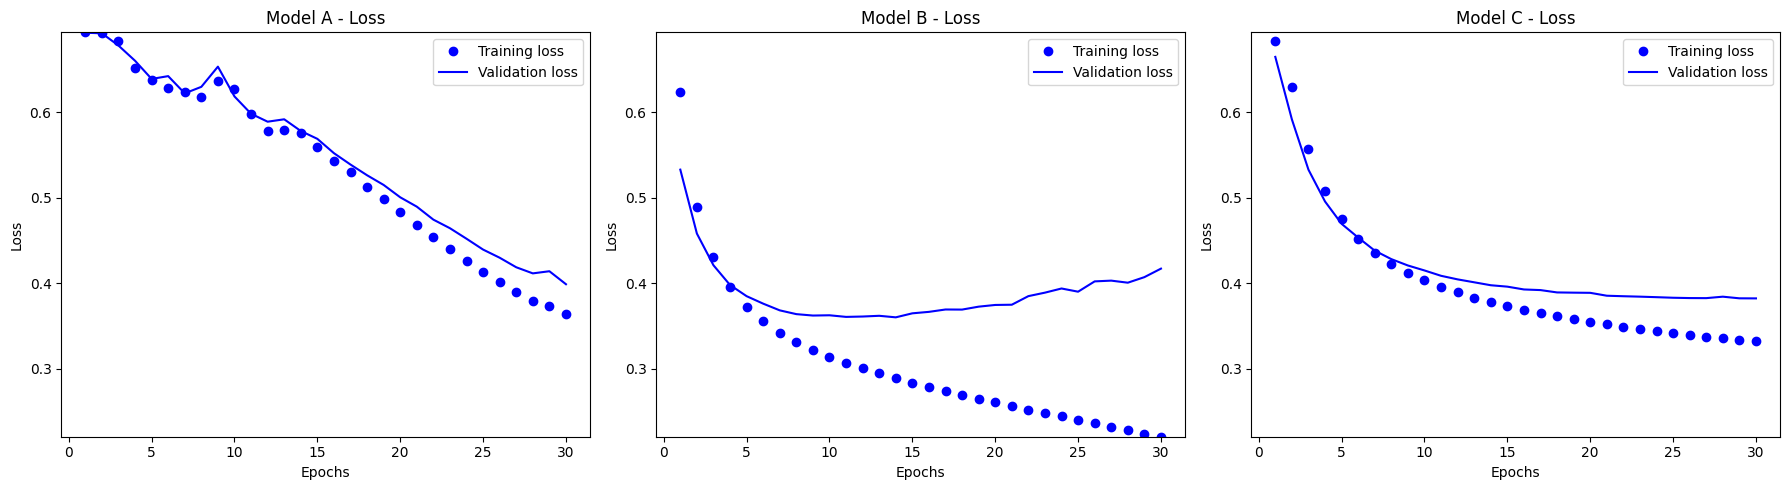

In [29]:
import matplotlib.pyplot as plt

# 전체 loss 값 모으기
all_losses = (
    history_model_A["train_losses"] + history_model_A["val_losses"] +
    history_model_B["train_losses"] + history_model_B["val_losses"] +
    history_model_C["train_losses"] + history_model_C["val_losses"]
)

y_min = min(all_losses)
y_max = max(all_losses)

# x축은 각 history 길이에 맞춤
epochs_A = range(1, len(history_model_A["train_losses"]) + 1)
epochs_B = range(1, len(history_model_B["train_losses"]) + 1)
epochs_C = range(1, len(history_model_C["train_losses"]) + 1)

plt.figure(figsize=(18, 5))

# Model A
plt.subplot(1, 3, 1)
plt.plot(epochs_A, history_model_A["train_losses"], 'bo', label='Training loss')
plt.plot(epochs_A, history_model_A["val_losses"], 'b', label='Validation loss')
plt.title('Model A - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(y_min, y_max)
plt.legend()

# Model B
plt.subplot(1, 3, 2)
plt.plot(epochs_B, history_model_B["train_losses"], 'bo', label='Training loss')
plt.plot(epochs_B, history_model_B["val_losses"], 'b', label='Validation loss')
plt.title('Model B - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(y_min, y_max)
plt.legend()

# Model C
plt.subplot(1, 3, 3)
plt.plot(epochs_C, history_model_C["train_losses"], 'bo', label='Training loss')
plt.plot(epochs_C, history_model_C["val_losses"], 'b', label='Validation loss')
plt.title('Model C - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(y_min, y_max)
plt.legend()

plt.tight_layout()
plt.show()


### 분석
#### model_A : LSTM 기반 감성 분류 모델(RNN Classifier)
- 진동이 작고, 전반적으로 안정적
- 정규화 장치가 없음
  - dropout X
  - weight decay X

#### model_B : TextCNN
- 세 모델 중 과적합이 가장 빨리 옴
- 이유?
  - 정규화 장치가 없음
    - dropout X
    - weight decay X
    - early stopping
  - Global max pooling은 ‘강한 패턴 1개’에 과민해지기 쉬움
    - train 데이터에서만 자주 나오는 “특정 강한 표현”을 잡고 외워버림
    - 검증에서는 그 패턴이 덜 나오면 loss가 다시 올라감

#### model_C : BoE(Embedding + GlobalMaxPool)
- train loss 내려가긴 하지만, A, B 모델보다 덜 내려감
- val loss 내려가다 정체, 이후 거의 평평함
- 이유?
  - BoE는 문맥/패턴을 거의 못 봐서 근본적으로 성능이

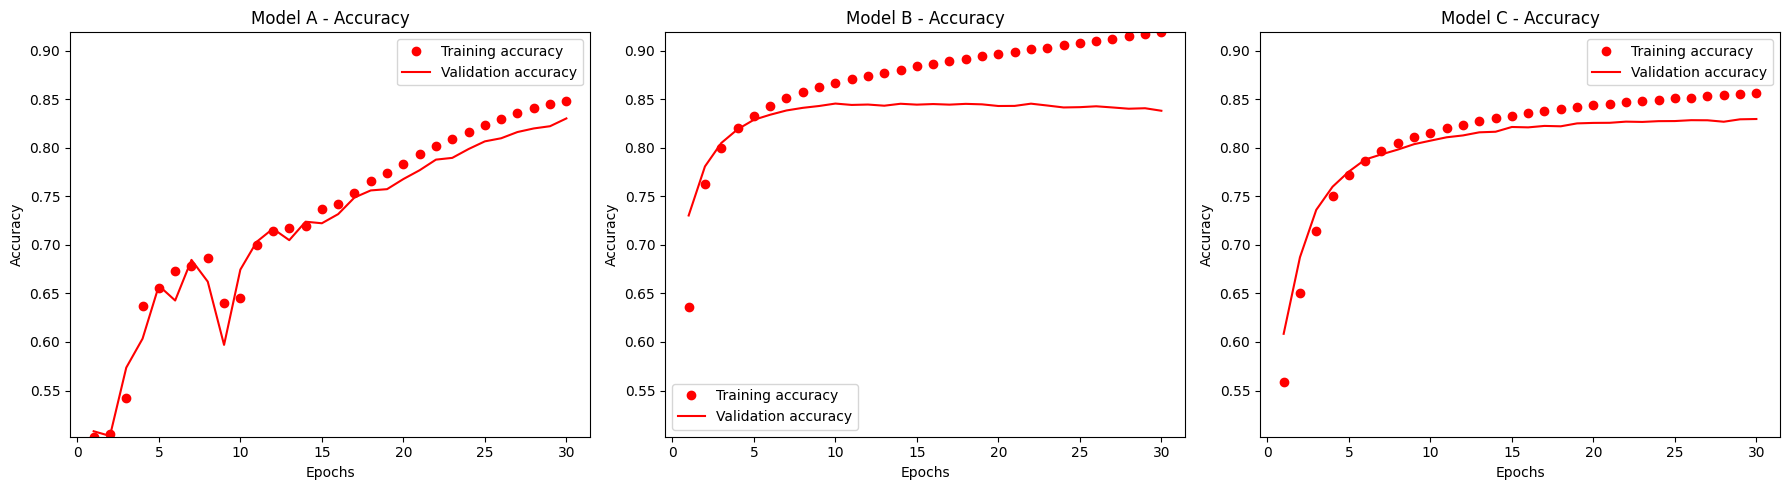

In [30]:
import matplotlib.pyplot as plt

# 전체 accuracy 값 모으기
all_accs = (
    history_model_A["train_accs"] + history_model_A["val_accs"] +
    history_model_B["train_accs"] + history_model_B["val_accs"] +
    history_model_C["train_accs"] + history_model_C["val_accs"]
)

y_min = min(all_accs)
y_max = max(all_accs)

# x축은 각 history 길이에 맞춤
epochs_A = range(1, len(history_model_A["train_accs"]) + 1)
epochs_B = range(1, len(history_model_B["train_accs"]) + 1)
epochs_C = range(1, len(history_model_C["train_accs"]) + 1)

plt.figure(figsize=(18, 5))

# Model A
plt.subplot(1, 3, 1)
plt.plot(epochs_A, history_model_A["train_accs"], 'ro', label='Training accuracy')
plt.plot(epochs_A, history_model_A["val_accs"], 'r', label='Validation accuracy')
plt.title('Model A - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(y_min, y_max)
plt.legend()

# Model B
plt.subplot(1, 3, 2)
plt.plot(epochs_B, history_model_B["train_accs"], 'ro', label='Training accuracy')
plt.plot(epochs_B, history_model_B["val_accs"], 'r', label='Validation accuracy')
plt.title('Model B - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(y_min, y_max)
plt.legend()

# Model C
plt.subplot(1, 3, 3)
plt.plot(epochs_C, history_model_C["train_accs"], 'ro', label='Training accuracy')
plt.plot(epochs_C, history_model_C["val_accs"], 'r', label='Validation accuracy')
plt.title('Model C - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(y_min, y_max)
plt.legend()

plt.tight_layout()
plt.show()


### Model A에 대하여 dropout, weight decay 적용해보기

In [31]:
# model_A에 dropout 추가하

import torch
import torch.nn as nn
import torch.nn.functional as F

# vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
# word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)
# # → 하나의 단어가 16차원짜리 벡터 하나로 표현되는 것!!

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
class SentimentModel_A2(nn.Module):
    def __init__(self, vocab_size, word_vector_dim, dropout=0.3):
        super(SentimentModel_A2, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.lstm = nn.LSTM(word_vector_dim, 8, batch_first=True)

        self.dropout = nn.Dropout(dropout)   # 추가
        
        self.fc1 = nn.Linear(8, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.embedding(x)
        x, (hn, cn) = self.lstm(x)
        x = x[:, -1, :]
        x = self.dropout(x)   # dropout 적용
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [32]:
model_A2 = SentimentModel_A2(10000, 16)
optimizer_A2 = optim.Adam(model_A2.parameters(), lr=1e-3, weight_decay=1e-4)  # model_A 옵티마이저 설정

In [33]:
history_model_A2 = train_one_model(
    model=model_A2,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_A2,
    loss_fn=loss_fn,
    epochs=50
)

Epoch 1/50 - Train Loss: 0.6964, Train Accuracy: 0.5045 - Validation Loss: 0.6925, Validation Accuracy: 0.5027
Epoch 2/50 - Train Loss: 0.6931, Train Accuracy: 0.5028 - Validation Loss: 0.6925, Validation Accuracy: 0.5027
Epoch 3/50 - Train Loss: 0.6930, Train Accuracy: 0.5043 - Validation Loss: 0.6925, Validation Accuracy: 0.5093
Epoch 4/50 - Train Loss: 0.6929, Train Accuracy: 0.5039 - Validation Loss: 0.6926, Validation Accuracy: 0.5027
Epoch 5/50 - Train Loss: 0.6928, Train Accuracy: 0.5044 - Validation Loss: 0.6925, Validation Accuracy: 0.5083
Epoch 6/50 - Train Loss: 0.6928, Train Accuracy: 0.5044 - Validation Loss: 0.6924, Validation Accuracy: 0.5085
Epoch 7/50 - Train Loss: 0.6928, Train Accuracy: 0.5021 - Validation Loss: 0.6924, Validation Accuracy: 0.5083
Epoch 8/50 - Train Loss: 0.6927, Train Accuracy: 0.5045 - Validation Loss: 0.6924, Validation Accuracy: 0.5080
Epoch 9/50 - Train Loss: 0.6927, Train Accuracy: 0.5044 - Validation Loss: 0.6923, Validation Accuracy: 0.5085
E

In [34]:
print("model_A2")
model_test(model_A2, test_loader)

model_A2
Test Loss: 0.6094, Test Accuracy: 0.7018


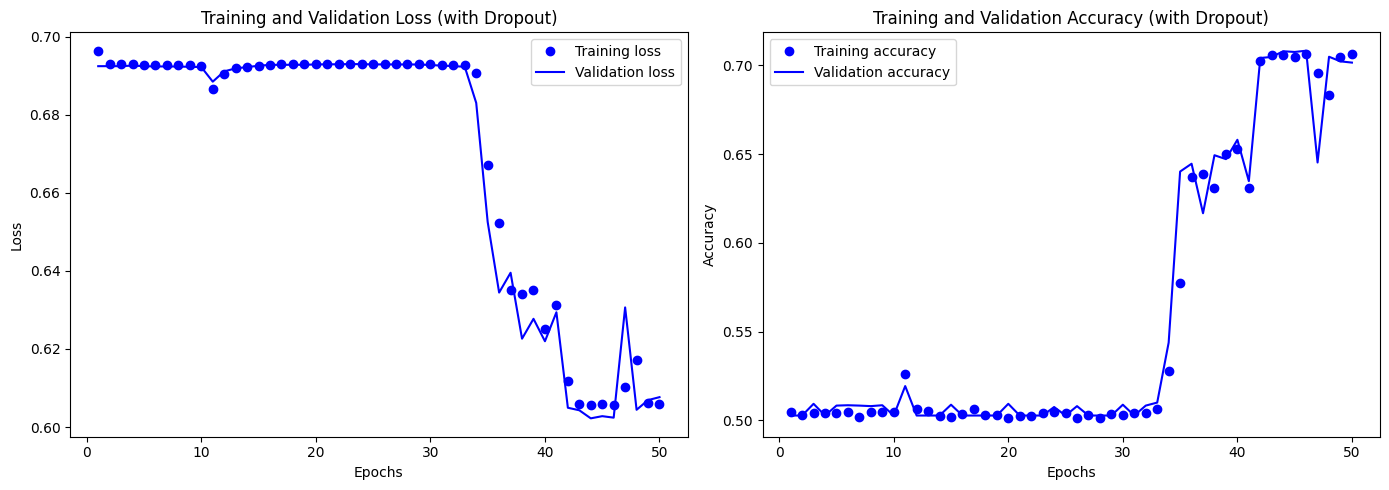

In [35]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(history_model_A2["train_losses"]) + 1)

plt.figure(figsize=(14, 5))

# 1) Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_model_A2["train_losses"], 'bo', label='Training loss')
plt.plot(epochs_range, history_model_A2["val_losses"], 'b', label='Validation loss')
plt.title('Training and Validation Loss (with Dropout)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 2) Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_model_A2["train_accs"], 'bo', label='Training accuracy')
plt.plot(epochs_range, history_model_A2["val_accs"], 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy (with Dropout)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## **7) 학습된 Embedding 레이어 분석**

In [36]:
embedding_layer = model_A.embedding
weights = embedding_layer.weight.detach().cpu().numpy()

print(weights.shape)  # shape: (vocab_size, embedding_dim)

(10000, 16)


In [37]:
vocab_size = 10000
word_vector_dim = 16

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path = os.path.join(os.getenv('HOME') + '/work/sentiment_classification/word2vec_emb/word2vec_model_A.txt')

with open(word2vec_file_path, 'w') as f:
    f.write('{} {}\n'.format(vocab_size - 4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다.
    vectors = model_A.embedding.weight.detach().cpu().numpy()
    for i in range(4, vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, vectors[i, :]))))

In [38]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['짜증']
vector

array([-1.1669887 ,  0.9622248 , -1.1979024 ,  0.20494571, -1.2685801 ,
        1.9223688 , -1.3191166 , -0.19105244,  0.5770296 ,  1.2532645 ,
        2.4610343 ,  0.9494333 ,  1.4830725 , -0.18573584,  0.03208966,
        0.17826803], dtype=float32)

In [39]:
# 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하는 방법
word_vectors.similar_by_word("짜증")

[('더빙', 0.7977690696716309),
 ('매드', 0.7835125923156738),
 ('앵', 0.7699297666549683),
 ('극치', 0.7608839869499207),
 ('장사', 0.7591597437858582),
 ('핸드폰', 0.7578079104423523),
 ('딘', 0.7495696544647217),
 ('어울리', 0.7406008243560791),
 ('한판', 0.7375591397285461),
 ('스티', 0.7366482019424438)]

## **8) 한국어 Word2Vec 임베딩 활용하여 성능 개선**

In [53]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_file_path = os.getenv("HOME") + '/work/sentiment_classification/data/word2vec_ko.model'

word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']

In [54]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in vector:
        embedding_matrix[i] = vector[index_to_word[i]]

In [49]:
# # model_A에 dropout 추가하기

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# # vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
# # word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)
# # # → 하나의 단어가 16차원짜리 벡터 하나로 표현되는 것!!

# # model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
# class SentimentModel_word2vec(nn.Module):
#     def __init__(self, vocab_size, word_vector_dim, embedding_matrix, dropout=0.3):
#         super(SentimentModel_word2vec, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, word_vector_dim)
#         self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
#         self.embedding.weight.requires_grad = True
#         self.lstm = nn.LSTM(word_vector_dim, 8, batch_first=True)

#         self.dropout = nn.Dropout(dropout)   # 추가
        
#         self.fc1 = nn.Linear(8, 8)
#         self.fc2 = nn.Linear(8, 1)

#     def forward(self, x):
#         x = self.embedding(x)
#         x, (hn, cn) = self.lstm(x)
#         x = x[:, -1, :]
#         x = self.dropout(x)   # dropout 적용
#         x = F.relu(self.fc1(x))
#         x = torch.sigmoid(self.fc2(x))
#         return x

In [55]:
model = SentimentModel_word2vec(vocab_size, word_vector_dim, embedding_matrix)
print(model)

SentimentModel_word2vec(
  (embedding): Embedding(10000, 300)
  (lstm): LSTM(300, 8, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)


In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SentimentModel_word2vec_B(nn.Module):
    def __init__(self, vocab_size, word_vector_dim, embedding_matrix, maxlen, dropout=0.3):
        super(SentimentModel_word2vec_B, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)    # 카피한 임베딩을 여기서 활용
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = True
        self.conv1 = nn.Conv1d(in_channels=word_vector_dim, out_channels=16, kernel_size=7)
        self.pool = nn.MaxPool1d(kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=7)
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(16, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.global_max_pool(x).squeeze(2)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

model = SentimentModel_word2vec_B(vocab_size, word_vector_dim, embedding_matrix, maxlen)
print(model)

SentimentModel_word2vec_B(
  (embedding): Embedding(10000, 300)
  (conv1): Conv1d(300, 16, kernel_size=(7,), stride=(1,))
  (pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 16, kernel_size=(7,), stride=(1,))
  (global_max_pool): AdaptiveMaxPool1d(output_size=1)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=16, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)


In [57]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn = torch.nn.BCELoss()

partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)

x_val_tensor = torch.tensor(x_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float)

train_dataset = TensorDataset(partial_x_train_tensor, partial_y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

# 학습의 진행
epochs = 10    # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.
train_losses = []
val_losses = []
train_accs = []
val_accs = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)  # cuda 또는 cpu 출력
model.to(device)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)

            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.4f} - "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.4f}")

/tmp/ipykernel_17910/1674690015.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
/tmp/ipykernel_17910/1674690015.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_tensor = torch.tensor(x_val, dtype=torch.long)


cuda
Epoch 1/10 - Train Loss: 0.6779, Train Accuracy: 0.5517 - Validation Loss: 0.5659, Validation Accuracy: 0.7351
Epoch 2/10 - Train Loss: 0.4976, Train Accuracy: 0.7755 - Validation Loss: 0.4141, Validation Accuracy: 0.8164
Epoch 3/10 - Train Loss: 0.4340, Train Accuracy: 0.8149 - Validation Loss: 0.3851, Validation Accuracy: 0.8284
Epoch 4/10 - Train Loss: 0.4078, Train Accuracy: 0.8297 - Validation Loss: 0.3802, Validation Accuracy: 0.8315
Epoch 5/10 - Train Loss: 0.3910, Train Accuracy: 0.8386 - Validation Loss: 0.3730, Validation Accuracy: 0.8352
Epoch 6/10 - Train Loss: 0.3788, Train Accuracy: 0.8453 - Validation Loss: 0.3606, Validation Accuracy: 0.8408
Epoch 7/10 - Train Loss: 0.3680, Train Accuracy: 0.8503 - Validation Loss: 0.3618, Validation Accuracy: 0.8442
Epoch 8/10 - Train Loss: 0.3575, Train Accuracy: 0.8556 - Validation Loss: 0.3552, Validation Accuracy: 0.8434
Epoch 9/10 - Train Loss: 0.3451, Train Accuracy: 0.8629 - Validation Loss: 0.3575, Validation Accuracy: 0.8

In [58]:
# 테스트셋을 통한 모델 평가
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

x_test_tensor = torch.tensor(x_test_padded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)

        test_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

Test Loss: 0.3668, Test Accuracy: 0.8375
